In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [2]:
# lattice and data directory
p0c = 43.36e6 # reference momentum in eV/c
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
data_dir = os.path.join('data', 'yaml_files')

In [3]:
# create gaussian and nongaussian beams using Bmad-X distgen functionality
gaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

nongaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

In [4]:
#plot gt beam
p0c = 10.0e6
save_dir = os.path.join('data','eex_beam')
eex_beam = create_beam(
    base_yaml = os.path.join(save_dir,'base.yaml'),
    transforms_yaml = os.path.join(save_dir,'transforms.yaml'),
    p0c = p0c,
#    save_as = os.path.join('gt_beam.pt'),
    n_particle=100_000
)

lims = np.array([[-4e-3, 4e-3],
                 [-3e-3, 3e-3],
                 [-5e-3, 5e-3],
                 [-3e-3, 3e-3],
                 [-3e-3, 4e-3],
                 [-2e-2, 2e-2]])

# swap x-z distributions
data = eex_beam.data.clone()
data = torch.index_select(data, -1, torch.tensor([4,1,2,3,0,5]))
data[:,1] = data[:,1] * 0.5 - data[:,0]
data[:,-1] = data[:,-1] * 3.0

eex_beam.data = data

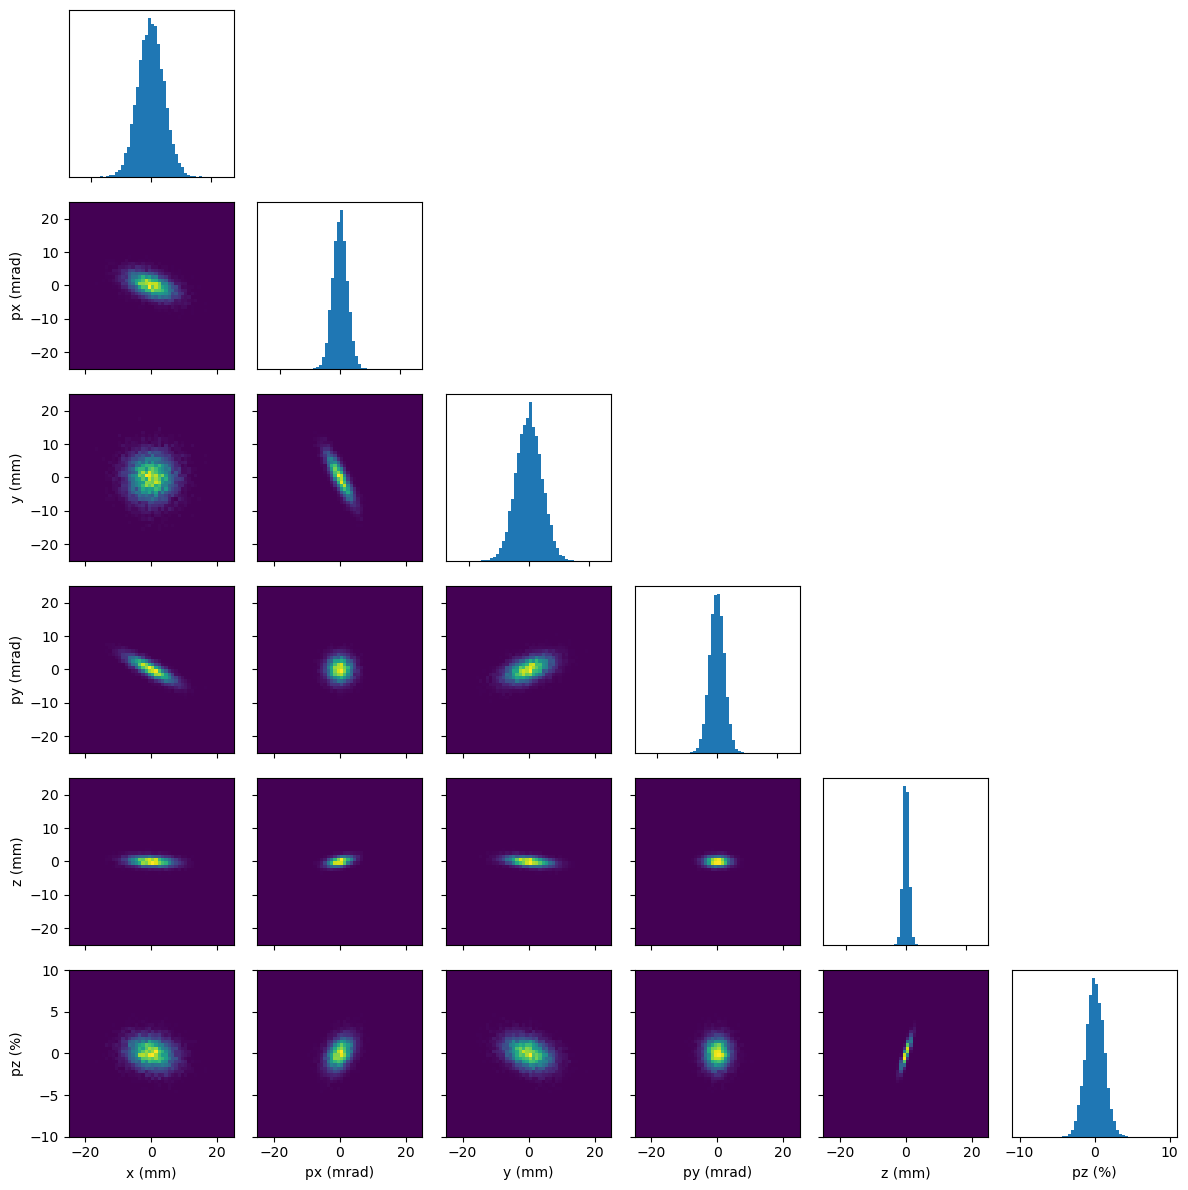

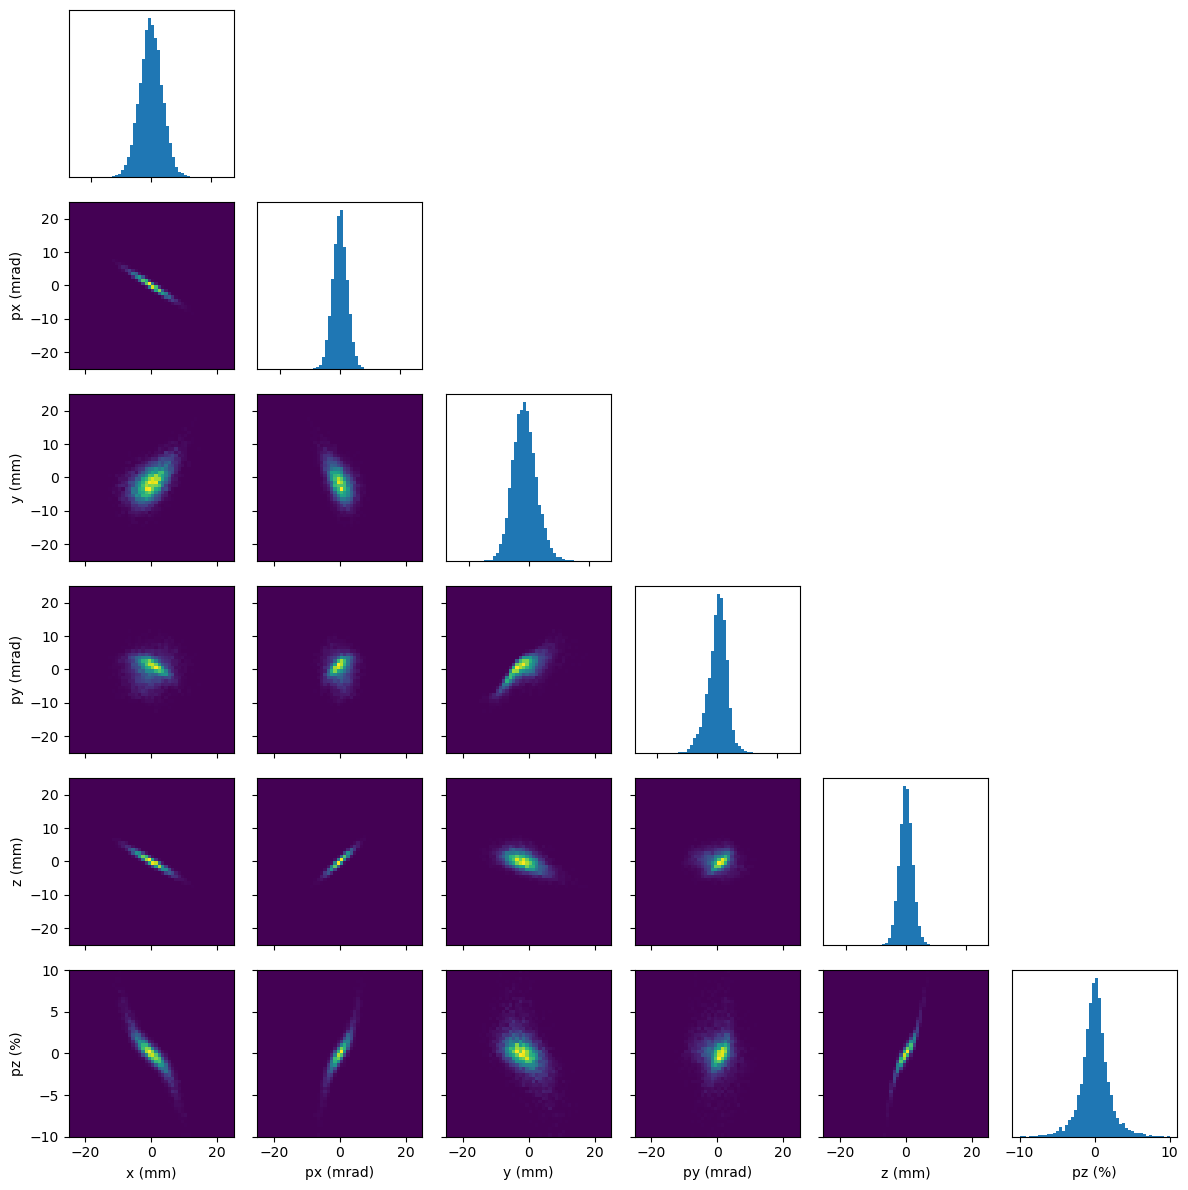

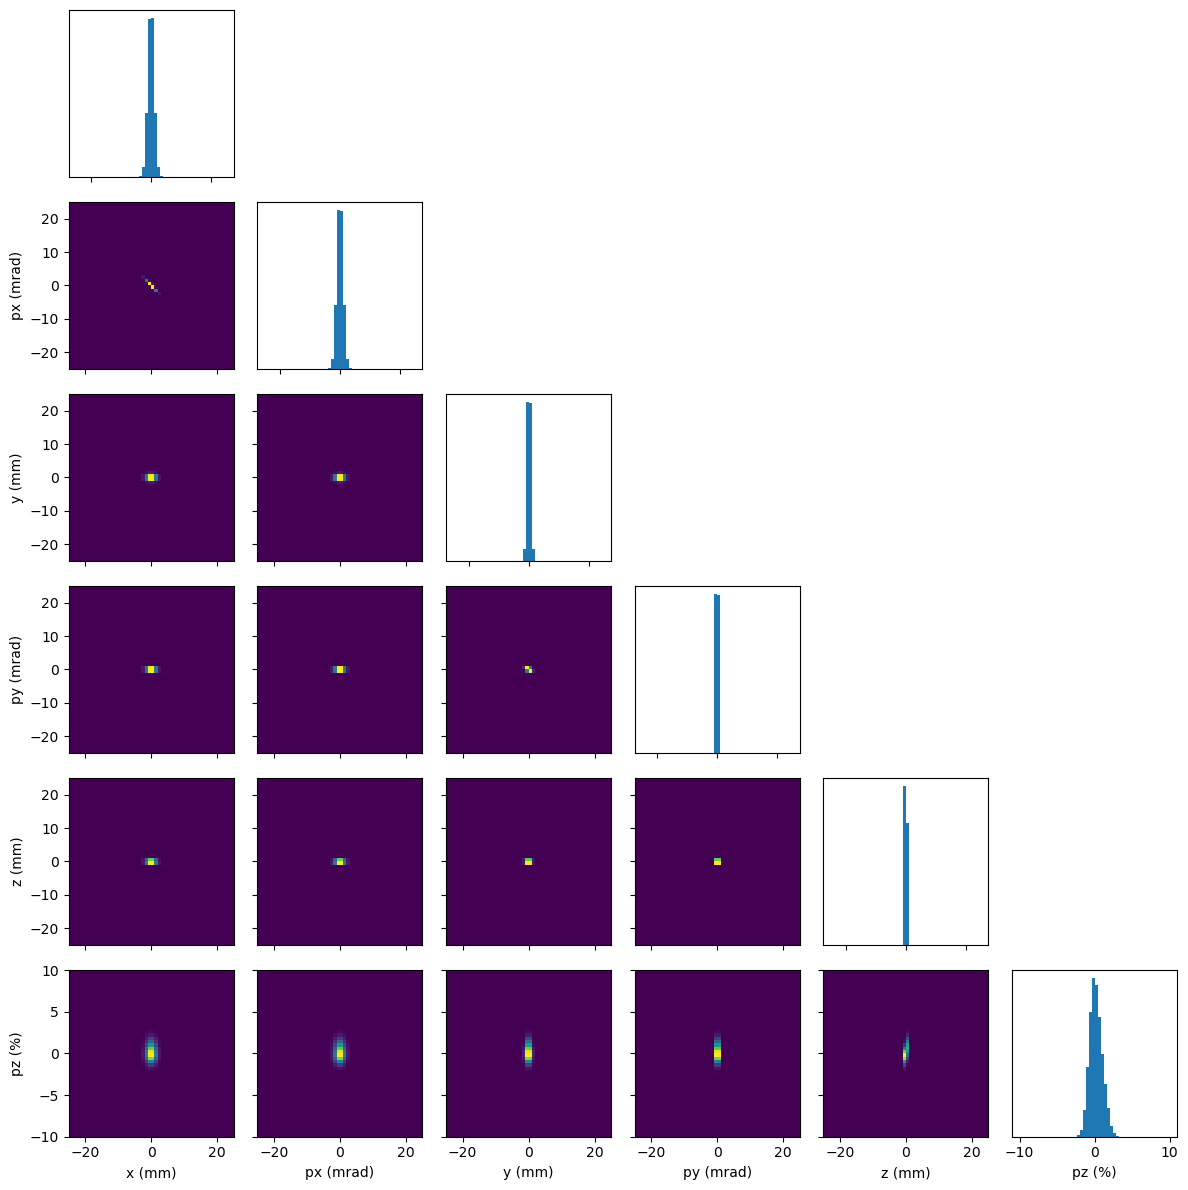

In [5]:
# plot linear and nonlinear beams
lims = np.array(
    [[-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-10e-2, 10e-2]]
    )
fig, ax = plot_projections(gaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(nongaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(eex_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [6]:
# use xopt for optimization
from triplet_opt import optimize_function, output
from xopt import VOCS

opt_vocs = VOCS(
        variables = {"k1":[0,30], "k2":[-30,0], "k3":[0,30]},
        objectives = {"total_size": "MINIMIZE"}
    )

if 0:
    opt_gaussian_beam = optimize_function(
        opt_vocs, output, n_iterations=100, 
        function_kwargs={
            'beam': gaussian_beam,
            'lattice': lattice,
        },
        generator_kwargs={"n_interpolate_points":5}
    )
print(".")
if 0:
    opt_nongaussian_beam = optimize_function(
        opt_vocs, output, n_iterations=100, 
        function_kwargs={
            'beam': nongaussian_beam,
            'lattice': lattice
        },
        generator_kwargs={"n_interpolate_points":5}
    )
print(".")

opt_eex_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': eex_beam,
        'lattice': lattice
    },
    generator_kwargs={"n_interpolate_points":5}
)

/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


.
.


In [7]:
# optimization results for linear beam
opt_gaussian_beam.data

NameError: name 'opt_gaussian_beam' is not defined

In [ ]:
opt_gaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

In [ ]:
# optimization results for nonlinear beam
opt_nongaussian_beam.data

In [ ]:
opt_nongaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

In [8]:
# optimization results for linear beam
opt_eex_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
0,13.892344,-24.696096,13.478634,0.010772,0.003061,0.782275,0.346662,False
1,5.692858,-9.274882,22.330724,0.000748,0.003549,0.283753,0.129174,False
2,1.452807,-22.281549,26.534758,0.000450,0.000692,0.025048,0.198541,False
3,13.636945,-17.678465,17.779102,0.003913,0.001354,0.259960,0.066157,False
4,15.247454,-24.765271,12.105958,0.012922,0.003548,0.950816,0.067036,False
...,...,...,...,...,...,...,...,...
501,4.234686,-12.088996,21.457915,0.000329,0.001999,0.169012,0.059901,False
502,3.951597,-17.854692,22.412355,0.000839,0.000579,0.027028,0.059837,False
503,3.668509,-23.620388,23.366795,0.001290,0.000976,0.033048,0.059780,False
504,3.385421,-29.386085,24.321235,0.001671,0.002289,0.064595,0.059697,False


In [9]:
opt_eex_beam.data.iloc[-1][["k1","k2", "k3"]]

k1     7.117084
k2   -21.630823
k3    26.233582
Name: 505, dtype: object

<Axes: >

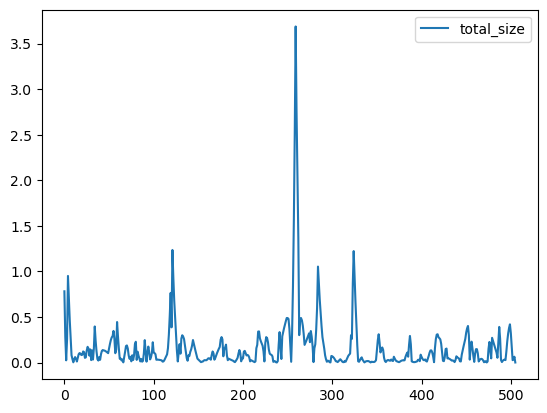

In [12]:
opt_eex_beam.data.plot(y="total_size")